# Network Troubleshooting. Hyperparameter Choice.

# keywords: learning rate, vanishing and exploding gradients, scheduler

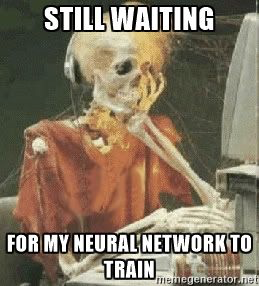

Training a neural network can be a time-consuming (and expensive) process. 
And if we want to build an effective solution, we may have to train it a hundred times, changing model/training parameters.

In [1]:
import os
os.environ['TENSORBOARD_BINARY']='/home/berend/anaconda3/envs/torch/bin/tensorboard'

What parameters (roughly in importance order) to alter?
1. Learning rate.
2. Architecture choice.
3. Dataset preprocessing.
4. Architecture parameters.
5. Optimizer.
6. Training time.
7. Batch size.
8. Optimizer parameters.

We will discuss (2,3,4) later.

# Learning rate (and a bit of batch size).

Rule of thumb: find the largest lr, when the model is still training. Divide by 2.

In [2]:
import torch

In [3]:
from torchvision import datasets, transforms
train_dataset = datasets.MNIST('../data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
test_dataset = datasets.MNIST('../data', train=False, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))
                                ]))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4096, shuffle=True)

Note: we increased the batch_size to speed up experiments a bit.

In [4]:
import torch.nn as nn
from torch.nn.modules import loss

class Flatten(nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1)

def get_model():
  return nn.Sequential(Flatten(), 
                       nn.Linear(784, 512), 
                       nn.Tanh(),
                       nn.Linear(512, 64), 
                       nn.Tanh(),
                       nn.Linear(64, 10))

loss_function = loss.CrossEntropyLoss()

def train(model, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        train_loss += loss.sum().item()
        loss.backward()
        optimizer.step()
        #writer.add_scalar("train-loss", loss)
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    writer.add_scalar("train-loss", train_loss, global_step=epoch)
            
def test(model, test_loader, loss_function, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss_function(output, target).sum().item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    writer.add_scalar("test-loss", test_loss, global_step=epoch)
    writer.add_scalar("test-accuracy", 100. * correct / len(test_loader.dataset), global_step=epoch)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [6]:
!rm -r logs1

In [7]:
%tensorboard --logdir logs1

In [8]:
def train_with_lr(lr, model, epochs=5, start_epoch=0):
    writer = SummaryWriter(log_dir=f"logs1/lr{lr}")
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(start_epoch, start_epoch + epochs):
        train(model, train_loader, optim, loss_function, epoch, writer)
        test(model, test_loader, loss_function, epoch, writer)
    writer.close()

In [9]:
model = get_model()
%time train_with_lr(2, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.333435

Test set: Average loss: 0.0139, Accuracy: 1009/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 47.111446

Test set: Average loss: 0.0082, Accuracy: 430/10000 (4%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 27.336664

Test set: Average loss: 0.0092, Accuracy: 2595/10000 (26%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 30.885632

Test set: Average loss: 0.0076, Accuracy: 3049/10000 (30%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 25.570158

Test set: Average loss: 0.0050, Accuracy: 4377/10000 (44%)

CPU times: user 49.4 s, sys: 317 ms, total: 49.7 s
Wall time: 32.6 s


In [10]:
 model = get_model()
%time train_with_lr(1, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.331602

Test set: Average loss: 0.0007, Accuracy: 5012/10000 (50%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.460497

Test set: Average loss: 0.0001, Accuracy: 8461/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.518724

Test set: Average loss: 0.0001, Accuracy: 9102/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.313632

Test set: Average loss: 0.0001, Accuracy: 9262/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.264591

Test set: Average loss: 0.0001, Accuracy: 9347/10000 (93%)

CPU times: user 48.8 s, sys: 156 ms, total: 49 s
Wall time: 32.2 s


lr = 0.5 should be ok.

In [11]:
model = get_model()
%time train_with_lr(0.5, model, epochs=5)

#%time train_with_lr(0.5, model, epochs=20)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.332592

Test set: Average loss: 0.0002, Accuracy: 8384/10000 (84%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.545740

Test set: Average loss: 0.0001, Accuracy: 8873/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.415979

Test set: Average loss: 0.0001, Accuracy: 9162/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.313850

Test set: Average loss: 0.0001, Accuracy: 9258/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.269662

Test set: Average loss: 0.0001, Accuracy: 9317/10000 (93%)

CPU times: user 48.7 s, sys: 116 ms, total: 48.8 s
Wall time: 32 s


### What happens if we return to 16 batch size?

In [12]:
def cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'):
    # type: (Tensor, Tensor, Optional[Tensor], Optional[bool], int, Optional[bool], str) -> Tensor
    r"""This criterion combines `log_softmax` and `nll_loss` in a single
    function.
    See :class:`~torch.nn.CrossEntropyLoss` for details.
    Args:
        input (Tensor) : :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
            in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
            in the case of K-dimensional loss.
        target (Tensor) : :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
            or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
            K-dimensional loss.
        weight (Tensor, optional): a manual rescaling weight given to each
            class. If given, has to be a Tensor of size `C`
        size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
            the losses are averaged over each loss element in the batch. Note that for
            some losses, there multiple elements per sample. If the field :attr:`size_average`
            is set to ``False``, the losses are instead summed for each minibatch. Ignored
            when reduce is ``False``. Default: ``True``
        ignore_index (int, optional): Specifies a target value that is ignored
            and does not contribute to the input gradient. When :attr:`size_average` is
            ``True``, the loss is averaged over non-ignored targets. Default: -100
        reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
            losses are averaged or summed over observations for each minibatch depending
            on :attr:`size_average`. When :attr:`reduce` is ``False``, returns a loss per
            batch element instead and ignores :attr:`size_average`. Default: ``True``
        reduction (string, optional): Specifies the reduction to apply to the output:
            ``'none'`` | ``'mean'`` | ``'sum'``. ``'none'``: no reduction will be applied,
            ``'mean'``: the sum of the output will be divided by the number of
            elements in the output, ``'sum'``: the output will be summed. Note: :attr:`size_average`
            and :attr:`reduce` are in the process of being deprecated, and in the meantime,
            specifying either of those two args will override :attr:`reduction`. Default: ``'mean'``
    Examples::
        >>> input = torch.randn(3, 5, requires_grad=True)
        >>> target = torch.randint(5, (3,), dtype=torch.int64)
        >>> loss = F.cross_entropy(input, target)
        >>> loss.backward()
    """
    if not torch.jit.is_scripting():
        tens_ops = (input, target)
        if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
            return handle_torch_function(
                cross_entropy, tens_ops, input, target, weight=weight,
                size_average=size_average, ignore_index=ignore_index, reduce=reduce,
                reduction=reduction)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)
    return nll_loss(log_softmax(input, 1), target, weight, None, ignore_index, None, reduction)

In [13]:
model = get_model()
%time train_with_lr(0.05, model, epochs=5, start_epoch=20)

Train Epoch: 20 [0/60000 (0%)]	Loss: 2.309001

Test set: Average loss: 0.0005, Accuracy: 7306/10000 (73%)

Train Epoch: 21 [0/60000 (0%)]	Loss: 1.586878

Test set: Average loss: 0.0003, Accuracy: 7890/10000 (79%)

Train Epoch: 22 [0/60000 (0%)]	Loss: 1.156592

Test set: Average loss: 0.0003, Accuracy: 8299/10000 (83%)

Train Epoch: 23 [0/60000 (0%)]	Loss: 0.905723

Test set: Average loss: 0.0002, Accuracy: 8543/10000 (85%)

Train Epoch: 24 [0/60000 (0%)]	Loss: 0.763898

Test set: Average loss: 0.0002, Accuracy: 8691/10000 (87%)

CPU times: user 50 s, sys: 200 ms, total: 50.2 s
Wall time: 33.1 s


In [14]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

In [15]:
def train_small_batch_with_lr(lr, model, epochs=5, start_epoch=0):
    writer = SummaryWriter(log_dir=f"logs1/lr{lr}_batch16")
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(start_epoch, start_epoch + epochs):
        train(model, train_loader, optim, loss_function, epoch, writer)
        test(model, test_loader, loss_function, epoch, writer)
    writer.close()

In [16]:
 model = get_model()
%time train_small_batch_with_lr(1, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314765
Train Epoch: 0 [3200/60000 (5%)]	Loss: 11.380527
Train Epoch: 0 [6400/60000 (11%)]	Loss: 16.950220
Train Epoch: 0 [9600/60000 (16%)]	Loss: 4.748849
Train Epoch: 0 [12800/60000 (21%)]	Loss: 11.621214
Train Epoch: 0 [16000/60000 (27%)]	Loss: 13.388723
Train Epoch: 0 [19200/60000 (32%)]	Loss: 8.002790
Train Epoch: 0 [22400/60000 (37%)]	Loss: 11.198373
Train Epoch: 0 [25600/60000 (43%)]	Loss: 9.132192
Train Epoch: 0 [28800/60000 (48%)]	Loss: 5.168027
Train Epoch: 0 [32000/60000 (53%)]	Loss: 22.894772
Train Epoch: 0 [35200/60000 (59%)]	Loss: 13.266792
Train Epoch: 0 [38400/60000 (64%)]	Loss: 12.543603
Train Epoch: 0 [41600/60000 (69%)]	Loss: 15.242846
Train Epoch: 0 [44800/60000 (75%)]	Loss: 13.222125
Train Epoch: 0 [48000/60000 (80%)]	Loss: 5.213948
Train Epoch: 0 [51200/60000 (85%)]	Loss: 9.203676
Train Epoch: 0 [54400/60000 (91%)]	Loss: 16.797295
Train Epoch: 0 [57600/60000 (96%)]	Loss: 14.618228

Test set: Average loss: 0.8031, Accuracy: 2105

In [17]:
 model = get_model()
%time train_small_batch_with_lr(0.1, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.314703
Train Epoch: 0 [3200/60000 (5%)]	Loss: 0.270493
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.410059
Train Epoch: 0 [9600/60000 (16%)]	Loss: 0.149275
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.480164
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.438944
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.484909
Train Epoch: 0 [22400/60000 (37%)]	Loss: 0.499211
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.064247
Train Epoch: 0 [28800/60000 (48%)]	Loss: 0.046567
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.021404
Train Epoch: 0 [35200/60000 (59%)]	Loss: 0.129607
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.167304
Train Epoch: 0 [41600/60000 (69%)]	Loss: 0.092534
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.155244
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.279188
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.223808
Train Epoch: 0 [54400/60000 (91%)]	Loss: 0.051507
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.056129

Test set: Average loss: 0.0083, Accuracy: 9603/10000 (96%)

# Scheduler - tweak learning rate during training

Sometimes it may be reasonable to alter learning rate during training. 

In [18]:
def train_with_scheduler(model, scheduler, optimizer, epochs=5, start_epoch=0):
    writer = SummaryWriter(log_dir=f"logs1/scheduler")
    for epoch in range(start_epoch, start_epoch + epochs):
        train(model, train_loader, optim, loss_function, epoch, writer)
        test(model, test_loader, loss_function, epoch, writer)
        
        # Call scheduler step after epoch!
        scheduler.step()
        
    writer.close()

In [19]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4096, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4096, shuffle=True)

In [20]:
model = get_model()
optim = torch.optim.SGD(model.parameters(), lr=1)

## Number of steps: 10 // gamma 0.1
# every 10 steps will multiply learning rate by 0.1
scheduler = torch.optim.lr_scheduler.StepLR(optim, 10, gamma=0.1, last_epoch=-1)

train_with_scheduler(model, scheduler, optim, epochs=5)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.326254

Test set: Average loss: 0.0008, Accuracy: 4425/10000 (44%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.851200

Test set: Average loss: 0.0001, Accuracy: 8525/10000 (85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.467865

Test set: Average loss: 0.0001, Accuracy: 9077/10000 (91%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.299548

Test set: Average loss: 0.0001, Accuracy: 9194/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.272119

Test set: Average loss: 0.0001, Accuracy: 9278/10000 (93%)



Another way to find good lr (Leslie N. Smith [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)): 

In [21]:
def lr_finder(model, train_loader, optimizer, loss_function):
    writer = SummaryWriter(log_dir=f"logs1/lr_finder6")
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 1.2, last_epoch=-1)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        writer.add_scalar("batch_loss", loss, global_step=batch_idx)
        writer.add_scalar("lr", torch.tensor(scheduler.get_last_lr()), global_step=batch_idx)
    writer.close()


In [22]:
model = get_model()

In [23]:
lr_finder(model, train_loader, torch.optim.SGD(model.parameters(), lr=0.1), loss_function)

# Optimizer

For most of CV tasks (classification/detection/segmentation):



Adam is one of the best optimizers to try first (with default parameters). Usually, it's not the best, but default parameters work reasonably well in most real-world scenarios. You may still need to tune lr/introduce a scheduler (do not use Smith's method for Adam), but due to its adaptive nature, the range of "proper" lrs is usually pretty large. It's prone to overfitting, so additional attention to regularization may be needed

In [24]:
optim = torch.optim.Adam(model.parameters())

SGD with properly tuned hyperparameters usually beats Adam (it may be worse on the train set but generalizes better). It may be pretty slow, so usually, step_scheduler is beneficial.

- Adam is really prone to overfitting
- Performance of train set Adam and SGD equal
- When you check on test set SGD > Adam
- Silly task: Adam, good learning rate

# Training time

Can be tuned "for free" using early stoping technique.

In [25]:
def train_with_lr_checkpoints(lr, model, checkpoint_dir, epochs=5, start_epoch=0):
    writer = SummaryWriter(log_dir=f"logs1/lr{lr}_checkpoints")
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(start_epoch, start_epoch + epochs):
        train(model, train_loader, optim, loss_function, epoch, writer)
        
        # Model state dict contains information of all the weights of the model
        # Basically torch can save any pythonic objects
        # Provide name for checkpoint
        # Save each checkpoint with different name
        torch.save(model.state_dict(), f"{checkpoint_dir}/epoch_{epoch}.pth")
        
        test(model, test_loader, loss_function, epoch, writer)
    writer.close()

In [26]:
model = get_model()

In [27]:
!rm -r checkpoints

In [28]:
!mkdir checkpoints

In [29]:
train_with_lr_checkpoints(0.5, model, "checkpoints")

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.293569

Test set: Average loss: 0.0002, Accuracy: 7776/10000 (78%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.643887

Test set: Average loss: 0.0001, Accuracy: 8863/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.424396

Test set: Average loss: 0.0001, Accuracy: 9178/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.311459

Test set: Average loss: 0.0001, Accuracy: 9261/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.274383

Test set: Average loss: 0.0001, Accuracy: 9248/10000 (92%)



In [30]:
# load the dictionary with weights
# load state dict directly to model

model.load_state_dict(torch.load("checkpoints/epoch_2.pth"))

<All keys matched successfully>

In [31]:
torch.load("checkpoints/epoch_2.pth")

OrderedDict([('1.weight',
              tensor([[ 0.0223, -0.0175,  0.0324,  ...,  0.0077,  0.0320,  0.0309],
                      [ 0.0026, -0.0284, -0.0068,  ..., -0.0018, -0.0311,  0.0277],
                      [-0.0191,  0.0354,  0.0095,  ..., -0.0305,  0.0060,  0.0172],
                      ...,
                      [-0.0166,  0.0105, -0.0297,  ..., -0.0021, -0.0309, -0.0103],
                      [-0.0241,  0.0007,  0.0333,  ..., -0.0145, -0.0227, -0.0210],
                      [ 0.0189,  0.0242, -0.0070,  ...,  0.0099,  0.0041, -0.0248]])),
             ('1.bias',
              tensor([ 0.0034, -0.0036, -0.0150, -0.0010,  0.0038, -0.0073,  0.0331,  0.0277,
                      -0.0034,  0.0135,  0.0208, -0.0205,  0.0059, -0.0297, -0.0177,  0.0238,
                      -0.0221, -0.0137, -0.0348, -0.0181,  0.0231, -0.0246,  0.0280,  0.0024,
                      -0.0349,  0.0047, -0.0229,  0.0058,  0.0046,  0.0147,  0.0009, -0.0303,
                      -0.0162,  0.0139, 

Most optimizers have some state too (i.e. momentum_buffer). If you are going to continue training your model after serialization, it's better to save their state (and epoch number for scheduler) too.


- save dictionary of your optimizer as well
- Because something can crash after two days, then suddenly electricity shuts down
- Reboot machine; you want to continue training
- Lost all information in your optimizer
- Therefore;

In [32]:
def train_with_lr_checkpoints_better(lr, model, optim, checkpoint_dir, epochs=5, start_epoch=0):
  writer = SummaryWriter(log_dir=f"logs1/lr{lr}_checkpoints_better")
  for epoch in range(start_epoch, start_epoch + epochs):
    train(model, train_loader, optim, loss_function, epoch, writer)
    state = {"model_state": model.state_dict(),
             "optimizer_state": optim.state_dict(),
             "epoch": epoch}
    torch.save(state, f"{checkpoint_dir}/epoch_{epoch}.pth")
    test(model, test_loader, loss_function, epoch, writer)
  writer.close()

In [33]:
model = get_model()
optim = torch.optim.SGD(model.parameters(), lr=0.5)

In [34]:
train_with_lr_checkpoints_better(0.5, model, optim, "checkpoints")

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.360739

Test set: Average loss: 0.0002, Accuracy: 8375/10000 (84%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.571429

Test set: Average loss: 0.0001, Accuracy: 8931/10000 (89%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.364183

Test set: Average loss: 0.0001, Accuracy: 9185/10000 (92%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.301352

Test set: Average loss: 0.0001, Accuracy: 9277/10000 (93%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.268589

Test set: Average loss: 0.0001, Accuracy: 9300/10000 (93%)



In [35]:
state = torch.load("checkpoints/epoch_2.pth")

In [36]:
state

{'model_state': OrderedDict([('1.weight',
               tensor([[-1.5695e-02,  3.5816e-02, -2.8768e-02,  ...,  3.2700e-02,
                        -2.7744e-02,  2.9323e-02],
                       [-3.9310e-03, -4.6187e-03, -2.0571e-02,  ..., -7.8336e-05,
                         2.5386e-02,  2.0814e-02],
                       [ 3.0839e-02,  8.8345e-03,  3.4440e-02,  ...,  3.3035e-02,
                        -7.2126e-03,  3.4973e-02],
                       ...,
                       [-2.1666e-02, -3.1431e-02,  2.8962e-02,  ..., -1.5052e-02,
                         2.8396e-02, -1.1577e-02],
                       [ 8.4248e-05, -3.5779e-02, -4.5316e-03,  ...,  3.3409e-02,
                         2.8393e-03,  1.3559e-02],
                       [ 1.7693e-02,  3.2936e-02, -1.0901e-02,  ...,  5.8651e-04,
                         3.1874e-02, -2.3722e-02]])),
              ('1.bias',
               tensor([-1.9338e-02,  1.2412e-02,  2.9732e-02, -8.5828e-03, -2.4695e-02,
                

In [37]:
model.load_state_dict(state["model_state"])

<All keys matched successfully>

In [38]:
optim.load_state_dict(state["optimizer_state"])

# Batch size

- Large batch size (with proper lr) usually trains faster (especially on GPU).
- Because GPU vector operations size doesnt matter


- Large batch size usually is easier to train (wider range of hyperparameters/models works).
- Less noise during SGD Better estimates of the real gradient

- Large batch size requires more RAM.
- VideoRAM when on GPU
- Fit your model in memory

- Large batch size is prone to overfitting.
- More stochastic gradient results in more randomness, decreasing chances to overfit
- Consistently changing the landscape where the optimizer is training

Usually "best" value is `32` - `1024`. It's better to use `2**x` for more effective memory usage.

# Optimizer parameters

Four methods:
1. Do not touch.
2. Grid search.
3. Random search.
4. ML/bayesian approaches. 

# Troubleshooting

## One-batch overfitting

In [39]:
first_batch = torch.utils.data.Subset(train_dataset, range(0, 64))

In [40]:
train_loader = torch.utils.data.DataLoader(first_batch, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(first_batch, batch_size=64, shuffle=True)

In [41]:
model = get_model()

In [42]:
train_with_lr(0.1, model, epochs=50)

Train Epoch: 0 [0/64 (0%)]	Loss: 2.331188

Test set: Average loss: 0.0329, Accuracy: 20/64 (31%)

Train Epoch: 1 [0/64 (0%)]	Loss: 2.106194

Test set: Average loss: 0.0300, Accuracy: 34/64 (53%)

Train Epoch: 2 [0/64 (0%)]	Loss: 1.917831

Test set: Average loss: 0.0274, Accuracy: 46/64 (72%)

Train Epoch: 3 [0/64 (0%)]	Loss: 1.751316

Test set: Average loss: 0.0250, Accuracy: 50/64 (78%)

Train Epoch: 4 [0/64 (0%)]	Loss: 1.599414

Test set: Average loss: 0.0228, Accuracy: 53/64 (83%)

Train Epoch: 5 [0/64 (0%)]	Loss: 1.459722

Test set: Average loss: 0.0208, Accuracy: 55/64 (86%)

Train Epoch: 6 [0/64 (0%)]	Loss: 1.331697

Test set: Average loss: 0.0190, Accuracy: 58/64 (91%)

Train Epoch: 7 [0/64 (0%)]	Loss: 1.215134

Test set: Average loss: 0.0173, Accuracy: 58/64 (91%)

Train Epoch: 8 [0/64 (0%)]	Loss: 1.109625

Test set: Average loss: 0.0159, Accuracy: 58/64 (91%)

Train Epoch: 9 [0/64 (0%)]	Loss: 1.014489

Test set: Average loss: 0.0145, Accuracy: 59/64 (92%)

Train Epoch: 10 [0/6

# Model inspection

If model can not overfit:
1. Check parameters. Get any subset of parameters (ex. [0:10] of the first linear layer). Check that they are changing.
2. Check gradients. For each parameter group print maximum absolute value of gradients. 

 a) If they are too large and growing uncontrollably, you can "clip" them. Choose a threshold m, and replace all gradients > m, by threshold value.
 
 b) If they are too small (usually for "starting" layers) you can tune lr for the specific layer, or change model architecture.

In [43]:
model

Sequential(
  (0): Flatten()
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): Tanh()
  (3): Linear(in_features=512, out_features=64, bias=True)
  (4): Tanh()
  (5): Linear(in_features=64, out_features=10, bias=True)
)

In [44]:
model[1]

Linear(in_features=784, out_features=512, bias=True)

In [45]:
# Absolute minimum of gradients
# too large -> exploding

model[1].weight.grad.abs().min()

tensor(9.7295e-10)

In [46]:
model[1].bias

Parameter containing:
tensor([ 1.1530e-02, -1.9092e-02, -9.9973e-03, -5.9740e-03,  1.2825e-02,
         1.0613e-02, -1.6039e-02, -9.1683e-03, -1.9080e-02,  2.5625e-02,
        -6.6578e-03, -8.3643e-03,  8.7057e-03,  1.5531e-02,  2.3122e-02,
         2.9726e-02, -3.1887e-02, -2.8381e-02,  2.8280e-02, -1.5231e-02,
         4.5521e-03, -3.3329e-03, -3.2305e-02, -3.1634e-02,  1.5389e-02,
        -1.8419e-02, -1.3785e-02, -2.3532e-02,  2.4307e-02,  2.2538e-02,
        -1.6117e-02, -1.0612e-02,  3.3071e-02, -1.1044e-02, -2.0750e-02,
         2.9211e-02, -4.4873e-03,  2.9080e-02, -2.5558e-02,  1.3982e-02,
         8.1497e-03,  2.3388e-02,  2.9698e-02,  3.3754e-02, -2.0395e-02,
        -3.5500e-02, -4.2628e-03,  3.4650e-02,  2.3042e-02, -8.3097e-03,
        -1.3756e-02,  2.1820e-02, -1.0300e-02, -1.4847e-03, -2.4382e-02,
         5.6283e-03, -5.0243e-03,  3.2017e-02,  1.1954e-02,  9.2521e-03,
         3.5681e-02,  1.8979e-02, -1.2218e-02, -3.1588e-02,  1.5241e-02,
        -1.6099e-02,  1.0542e

In [47]:
(model[1].bias / model[1].bias.grad).min()

tensor(-372022.5000, grad_fn=<MinBackward1>)

# Assignment

## 1. Find the best learning rate for our model for SGD optimizer and batch_size=64. Use both methods we discussed in the class [2].

It depends on the implementation of the loss function.

Reducing the batch size increases the amount of batches, because the dataset size remains the same.

Therefore you want to increase the lr?

Tricky question: because the reduction is important. Cross-entropy is defined for single test sample. In batch you have multiple samples, the big question is how to compute the loss for the batch

You can compute sum or mean loss of the batch. Mean reduction you compute the mean loss of the batch. If you do sum, you compute sum of the losses of the batch.

If your reduction is sum, and you have larger batch, you have larger learning rate automatically. Therefore you need to reduce the learning rate to keep it equal

If you have mean, you take average batch loss. When you increase batch size, decrease learning rate. Why? During epoch if your batch is small (16), then during the epoch you will make epochsize/16 updates. if batch=4000, then you only have 2 minibatches during epoch therefore only 2 updates to the weights. Therefore reduce learning rate.

But why do we want to keep the updates similar? The smaller the batch the more noise, SGD noise. If grads are noisy dont make big steps. You can jump too far out of sweet point.

In [48]:
def cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100,
                  reduce=None, reduction='mean'): 
    if not torch.jit.is_scripting():
        tens_ops = (input, target)
        if any([type(t) is not Tensor for t in tens_ops]) and has_torch_function(tens_ops):
            return handle_torch_function(
                cross_entropy, tens_ops, input, target, weight=weight,
                size_average=size_average, ignore_index=ignore_index, reduce=reduce,
                reduction=reduction)
    if size_average is not None or reduce is not None:
        reduction = _Reduction.legacy_get_string(size_average, reduce)
    return nll_loss(log_softmax(input, 1), target, weight, None, ignore_index, None, reduction)

So, because we used this cell, we are using mean reduction, indicating that we have to reduce learning rate compared to the previous situation. Therefore we will start with 1, as this is a bit higher than the best learning rate from the previous experiment.

### Method 1: Iterative approach

In [49]:
!rm -r assignment_1

In [50]:
%tensorboard --logdir assignment_1

In [51]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [52]:
def train_with_lr(lr, model, epochs=5, start_epoch=0):
    writer = SummaryWriter(log_dir=f"assignment_1/lr{lr}")
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(start_epoch, start_epoch + epochs):
        train(model, train_loader, optim, loss_function, epoch, writer)
        test(model, test_loader, loss_function, epoch, writer)
    writer.close()

In [53]:
model = get_model()
%time train_with_lr(1, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300630
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.285916
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.227448
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.238565
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.103498

Test set: Average loss: 0.0034, Accuracy: 9352/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.223442
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.436734
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.103453
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.151440
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.040939

Test set: Average loss: 0.0032, Accuracy: 9410/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.074440
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.059371
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.098138
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.069253
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.098371

Test set: Average loss: 0.0027, Accuracy: 9493/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.067314
Train Epoch: 3 [12800/60000 (21%)]	Lo

In [54]:
model = get_model()
%time train_with_lr(0.5, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.343856
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.207057
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.122596
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.077067
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.116888

Test set: Average loss: 0.0022, Accuracy: 9541/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.103457
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.321741
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.026052
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.067543
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.072113

Test set: Average loss: 0.0017, Accuracy: 9648/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.077548
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.211888
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.022682
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.024222
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.067009

Test set: Average loss: 0.0016, Accuracy: 9693/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.034145
Train Epoch: 3 [12800/60000 (21%)]	Lo

In [55]:
model = get_model()
%time train_with_lr(0.25, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.319368
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.231036
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.190915
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.160519
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.199337

Test set: Average loss: 0.0021, Accuracy: 9612/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.194584
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.048352
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.069824
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.070126
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.041362

Test set: Average loss: 0.0014, Accuracy: 9717/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.070944
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.080643
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.229492
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.006766
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.046128

Test set: Average loss: 0.0019, Accuracy: 9597/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.093900
Train Epoch: 3 [12800/60000 (21%)]	Lo

In [56]:
model = get_model()
%time train_with_lr(0.0625, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.345809
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.474877
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.161824
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.249488
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.152414

Test set: Average loss: 0.0032, Accuracy: 9409/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.253475
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.075486
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.126115
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.064182
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.068169

Test set: Average loss: 0.0021, Accuracy: 9625/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.182599
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.132140
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.107427
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.044507
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.297281

Test set: Average loss: 0.0019, Accuracy: 9624/10000 (96%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.075243
Train Epoch: 3 [12800/60000 (21%)]	Lo

So, the learning rate of 0.25 gives the best test loss reduction in 4 epochs, therefore we choose the learning rate with the iterative approach as 0.25

### Method 2: Exponential LR with scheduler

Another way to find good lr (Leslie N. Smith [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)): 

- Fast way to find good learning rate for a model
- Train model for single epoch, and use shcheduler
- exponential scheduler; multiply learning rate by certain value: 1.2 after each epoch
- increase learning rate (unusual)
- scheduler step() after each batch.
- increase lr fast!
- idea: small with really small enough lr, and make it explode
- push the boundaries of the starting learning rate.

## Example of tactic:

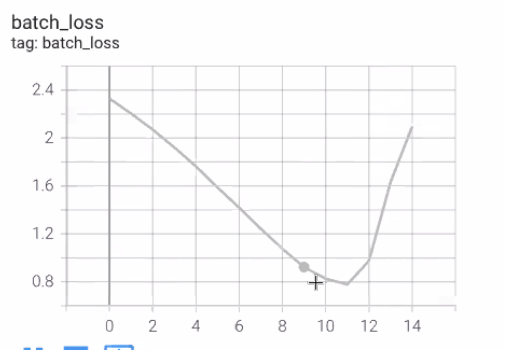

Look at the spot with the highest gradient -> best learning rate, that is epoch 5

then look up learning rate in the learning rate tracker:

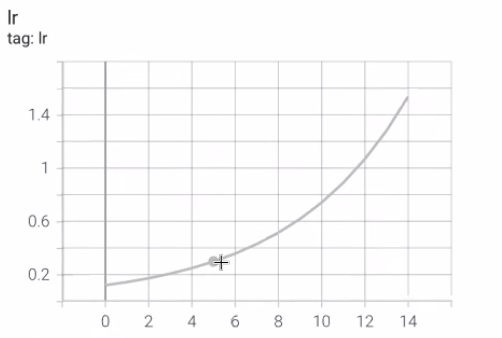

so about 0.3

Usually not a good idea to use exponential learning rate

In [57]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

In [58]:
def lr_finder(model, train_loader, optimizer, loss_function):
    writer = SummaryWriter(log_dir=f"assignment_1/exp_lr_batch_scheduler")
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 1 + 10**(-5)
, last_epoch=-1)
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        writer.add_scalar("batch_loss", loss, global_step=batch_idx)
        writer.add_scalar("lr", torch.tensor(scheduler.get_last_lr()), global_step=batch_idx)
    writer.close()


In [59]:
model = get_model()

In [60]:
lr_finder(model, train_loader, torch.optim.SGD(model.parameters(), lr=0.25/2/2/2/2/2), loss_function)

#### So in our case steepest slope in batch loss function around step 50

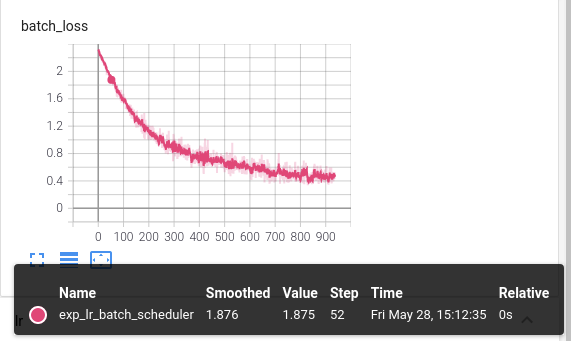

#### Therefore we pick the learning rate corresponding to step 50, which in our case is 7.8.e**(-6)

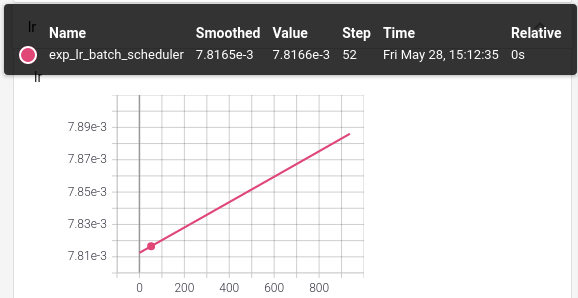

## 2. How large is the maximal absolute value of the gradient in the model after the first training batch? Set threshold to half the value of the largest gradient and clip gradients with this threshold. How does it affect the training? [2]

If model can not overfit:
1. Check parameters. Get any subset of parameters (ex. [0:10] of the first linear layer). Check that they are changing.
2. Check gradients. For each parameter group print maximum absolute value of gradients. 

 a) If they are too large and growing uncontrollably, you can "clip" them. Choose a threshold m, and replace all gradients > m, by threshold value.
 
 b) If they are too small (usually for "starting" layers) you can tune lr for the specific layer, or change model architecture.

### How large is the maximal absolute value of the gradient in the model after the first training batch?

Added the following piece to the training function to compute the maximum of the absolute value of the gradients currently present in the model:
        
        clip them by largest grad in batch
        grads = []
        for param in model.parameters():
            grads.append(torch.norm(param.grad.view(-1)).numpy())
        clip_threshold = 0.5 * max(grads)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_threshold)

### Set threshold to half the value of the largest gradient and clip gradients with this threshold.

In [61]:
def train_normalize_grad(model, train_loader, optimizer, loss_function, epoch, writer):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        train_loss += loss.sum().item()
        loss.backward()
        
        # clip them by largest grad in batch
        grads = []
        for param in model.parameters():
            grads.append(torch.norm(param.grad.view(-1)).numpy())
        clip_threshold = 0.5 * max(grads)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_threshold)

        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_loss /= len(train_loader.dataset)
    writer.add_scalar("train-loss", train_loss, global_step=epoch)

In [62]:
!rm -r assignment_2

In [63]:
%tensorboard --logdir assignment_2

In [64]:
def train_with_lr(lr, model, epochs=5, start_epoch=0):
    writer = SummaryWriter(log_dir=f"assignment_2/train_with_lr")
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(start_epoch, start_epoch + epochs):
        train(model, train_loader, optim, loss_function, epoch, writer)
        test(model, test_loader, loss_function, epoch, writer)
    writer.close()

In [65]:
def train_normalize_by_maxgrad(lr, model, epochs=5, start_epoch=0):
    writer = SummaryWriter(log_dir=f"assignment_2/normalize_max_grad")
    optim = torch.optim.SGD(model.parameters(), lr=lr)
    for epoch in range(start_epoch, start_epoch + epochs):
        
        ##  NORMALIZED VERSION!train_normalize_by_maxgrad
        train_normalize_grad(model, train_loader, optim, loss_function, epoch, writer)
        
        test(model, test_loader, loss_function, epoch, writer)
    writer.close()

In [66]:
model = get_model()
%time train_with_lr(0.25, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.338304
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.268863
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.139648
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.067806
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.098462

Test set: Average loss: 0.0020, Accuracy: 9608/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.083587
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.060018
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.044432
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.066628
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.051725

Test set: Average loss: 0.0017, Accuracy: 9655/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.121158
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.165695
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.022353
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.117109
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.093203

Test set: Average loss: 0.0013, Accuracy: 9739/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.003858
Train Epoch: 3 [12800/60000 (21%)]	Lo

In [67]:
model = get_model()
%time train_normalize_by_maxgrad(0.25, model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.346604
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.351060
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.313488
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.136479
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.183242

Test set: Average loss: 0.0028, Accuracy: 9479/10000 (95%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.156691
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.135299
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.245108
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.112488
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.211961

Test set: Average loss: 0.0021, Accuracy: 9568/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.100856
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.108987
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.191671
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.161536
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.085007

Test set: Average loss: 0.0015, Accuracy: 9703/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.023325
Train Epoch: 3 [12800/60000 (21%)]	Lo

### How does it affect the training?

Above I defined two train functions, and I mapped them to the same tensorboard. Below are the IMG results.

The training seems to be comparable.

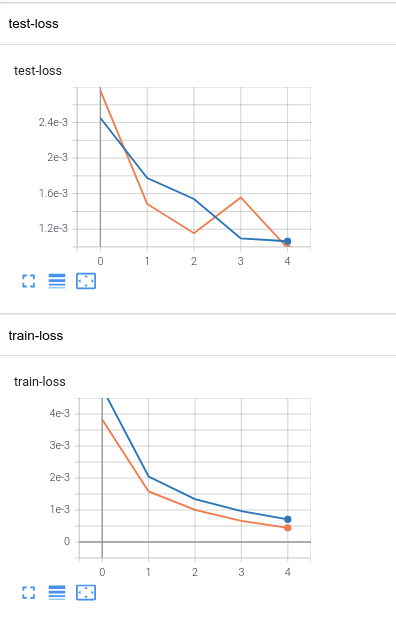

## 3. Modify model/loss function in such a way that it's still trainable with Adam optimizer, but it is not trainable with Adam optimizer with default parameters/learning rate. [3]

In [155]:
!rm -r assignment_3

rm: cannot remove 'assignment_3': No such file or directory


In [156]:
import torchvision.models as models

In [157]:
import math
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)
        
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) 
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound) 

    def forward(self, x):
        w_times_2 = self.weights * 2
        w_times_x = torch.mm(x, w_times_2.t())
        return torch.add(w_times_x, self.bias)

In [158]:
import torch.nn as nn
from torch.nn.modules import loss

class Flatten(nn.Module):
  def forward(self, x):
    batch_size = x.shape[0]
    return x.view(batch_size, -1)

def get_model_special():
  return nn.Sequential(Flatten(), 
                       CustomLinearLayer(784, 512), 
                       nn.Tanh(),
                       CustomLinearLayer(512, 64), 
                       nn.Tanh(),
                       CustomLinearLayer(64, 10))

In [159]:
%tensorboard --logdir assignment_3

Reusing TensorBoard on port 6006 (pid 484406), started 0:09:37 ago. (Use '!kill 484406' to kill it.)

In [160]:
loss_function = loss.CrossEntropyLoss()

In [161]:
def train_with_standard_adam(model, epochs=10, start_epoch=0):
    writer = SummaryWriter(log_dir=f"assignment_3/standard_adam")
    model
    optim = torch.optim.Adam(model_special.parameters())
    
    for epoch in range(start_epoch, start_epoch + epochs):
        train(model, train_loader, optim, loss_function, epoch, writer)
        test(model, test_loader, loss_function, epoch, writer)
    writer.close()

In [162]:
def train_with_special_adam(lr, model, epochs=10, start_epoch=0):
    writer = SummaryWriter(log_dir=f"assignment_3/special_adam")
    
    optim = torch.optim.Adam(model_special.parameters(), lr)
    
    for epoch in range(start_epoch, start_epoch + epochs):
        train(model, train_loader, optim, loss_function, epoch, writer)
        test(model, test_loader, loss_function, epoch, writer)
    writer.close()

In [163]:
model_special = get_model_special()
%time train_with_standard_adam(model)

Train Epoch: 0 [0/60000 (0%)]	Loss: 80.072624
Train Epoch: 0 [12800/60000 (21%)]	Loss: 85.612144
Train Epoch: 0 [25600/60000 (43%)]	Loss: 88.797333
Train Epoch: 0 [38400/60000 (64%)]	Loss: 95.726212
Train Epoch: 0 [51200/60000 (85%)]	Loss: 100.312943

Test set: Average loss: 1.4450, Accuracy: 951/10000 (10%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 89.656982
Train Epoch: 1 [12800/60000 (21%)]	Loss: 93.259155
Train Epoch: 1 [25600/60000 (43%)]	Loss: 89.387131
Train Epoch: 1 [38400/60000 (64%)]	Loss: 96.424492
Train Epoch: 1 [51200/60000 (85%)]	Loss: 100.006958

Test set: Average loss: 1.4464, Accuracy: 951/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 94.460899
Train Epoch: 2 [12800/60000 (21%)]	Loss: 97.853630
Train Epoch: 2 [25600/60000 (43%)]	Loss: 90.781464
Train Epoch: 2 [38400/60000 (64%)]	Loss: 87.721718
Train Epoch: 2 [51200/60000 (85%)]	Loss: 100.623123

Test set: Average loss: 1.4490, Accuracy: 951/10000 (10%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 76.502045
Train Epoch: 3 [12800

In [164]:
model_special = get_model_special()
%time train_with_special_adam(1e-05, model_special)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.423337
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.269478
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.856251
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.671989
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.609251

Test set: Average loss: 0.0075, Accuracy: 8905/10000 (89%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.506898
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.344938
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.328780
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.301324
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.364639

Test set: Average loss: 0.0054, Accuracy: 9174/10000 (92%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.348337
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.280958
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.417065
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.381868
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.350685

Test set: Average loss: 0.0045, Accuracy: 9266/10000 (93%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.249500
Train Epoch: 3 [12800/60000 (21%)]	Lo

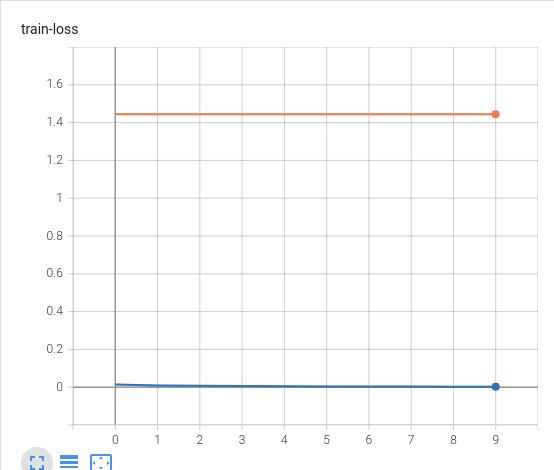

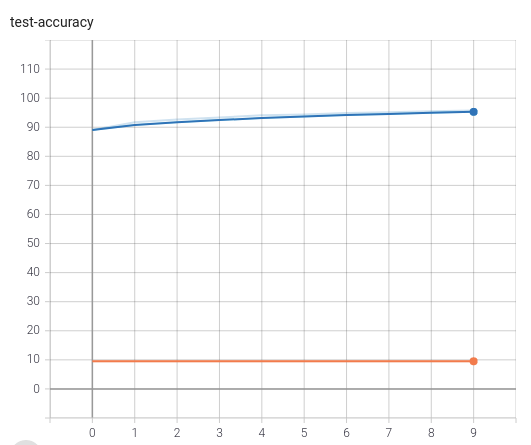

### 4. **Overfitting to the test set**. 

Consider a dog/cat classification problem. Let's assume that our architecture/training aproach is really bad and the test result for the model after training is random (for each image, there is an independent 50% probability of classifying it as a dog).


During hyperparameter tuning, we made ~1000 training runs (all results were still bad but independent). If we have a test dataset of 10 images, what is the expected accuracy of the best run? [3]

 1. 50% chance of classifying an image as a dog after training
 2. 1000 training runs on the full dataset
 3. The test dataset is 10 images

Q: What is the expected accuracy of the best run?

#### Task 4 solution idea:

Let $a_{i,n}$ be the probability that after $n$ experiments, maximal number of correct predictions in single experiment is $i$. 

And $p_i$ is the probablity to have $i$ correct predictions. Then 


$$a_{i,n+1} = \sum_{j \le i} a_{j, n} \times p_i + \sum_{j < i} a_{i, n} \times p_j$$

Correct answer is between 9 and 10.

This mean that we may overfit to test dataset indeed.

Solution: validation dataset.

- You had some network, but its training as good as random guess (dog / cat). 
- But you still are running hyperparameter search on the test set.
- Therefore, the hyperparameters are overfitting to the test set
- The goal is to estimate expected value of the accuracy
- The maximum number of succeses would be $i$
- Then there are two possiblities:

 1. 
 - Either there is exactly $i$ succeses in the last experiment
 - And there were no more than $i$ succeses during the first $n$ experiments
 
 2.
 - Or there is less than $i$ succeses in the last experiment
 - And the maximal number of correct predictions in the previous experiment was i exactly
 
 
##### Lesson: Whenever you are doing hyperparameter search you need a validation set

We have test dataset of 10 samples and for each sample success rate is 50%.
We want to find expectation of maximal number of correct predictions if we repeat experiment $n$ times.
Let's assume we run 10 experiments: 

- 1st run: 3 correct predictions
- 2nd: 5 correct
- 3d: 6
- 4th: 5
- 5th: 5
- 6th: 4
- 7th: 7
- 8th: 6
- 9th: 5
- 10th: 3

The maximal number of correct predictions is 7 for this run.

And on average if we run just 10 experiments it will be somewhere between 6 and 7. When we run more experiments, the expected number of maximal correct predictions increases (and for 1000 experiments it will be close to 10, as there is a pretty large chance that there will be at least one experiment where we made all 10 predictions correctly). The task is to estimate this number.

This is indeed the measure of overfitting to the test set. If you run multiple experiments (changing hyperparameters, training time, etc.) and select the best result looking at performance on the test dataset it'll be larger than real performance of your model for the reason above. That's why in real world you should always use 3 datasets (alt. crosswalidation): training, validation (you test on it and select hyperparameters which lead to the best performance on the validation dataset) and test dataset (once the best model is selected you test it on the test dataset to find real performance of your model).

#### Solution

In [1]:
n = 1000

A_term1 = []
A_term2 = []

p_0 = 0.5

a_next = 0
for i in range(n):
    term1 = 
    term2 =
    
    A_term1.append(term1)
    A_term2.append(term2)

    a_next = sum(A_term1) + sum(A_term2)
    


SyntaxError: invalid syntax (<ipython-input-1-e798dfed8bbf>, line 8)